# Mini Project: Natural Language Processing with Disaster Tweets


## Introduction

In an age dominated by digital communication and social media, information travels faster than ever before. Twitter, with its real-time and unfiltered nature, has become a significant platform for sharing news, opinions, and updates during crises and disasters. However, in this vast sea of tweets, distinguishing between legitimate disaster-related information and non-relevant content can be a formidable challenge. The project "Natural Language Processing with Disaster Tweets," addresses this critical issue by harnessing the power of natural language processing (NLP) and machine learning. The primary goal of this project is to develop a robust NLP-based model capable of accurately classifying tweets as either related to real disasters or unrelated.

## Data Preprocessing


Data Information:

- id : a unique identifier for each tweet
- text : the text of the tweet
- location : the location the tweet was sent from
- keyword : a particular keyword from the tweet
- target : whether a tweet is about a real disaster(1) or not(0)

### Loading libraries

In [4]:
# mount google drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pip install tensorflow_text

  Using cached tensorflow_text-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)


In [48]:

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

### Loading the data

In [7]:
# load the data
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nlp_tweeter_disaster/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nlp_tweeter_disaster/test.csv")

### Simple EDA

The training data consists of 7,613 rows and 5 columns, while the test data comprises 3,263 rows and 4 columns. The dataset is of moderate size. To provide a better understanding of the data structure, We've included 10 examples from both the training and test datasets below.

In [8]:
# The shape of each dataset

print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


In [9]:
# sample of train data

train.sample(10)

,id,keyword,location,text,target
161,232,airplane%20accident,Havenford,+ Nicole Fletcher one of a victim of crashed a...,1
3590,5128,fatal,"Laredo, TX",Petition to remaster Fatal Frame 1 with a Wind...,0
5295,7563,outbreak,Italy,Families to sue over Legionnaires: More than 4...,1
4440,6318,hostage,NaN,I sent my emails why are the TRINNA hold me ho...,0
5303,7576,outbreak,"Nottingham, United Kingdom",@DrAtomic420 where did you get that pic from w...,0
2373,3412,derail,NaN,BBC News - India rail crash: Trains derail in ...,1
6420,9180,suicide%20bomber,NaN,IS claims suicide bombing against Saudi police...,1
490,710,attacked,AKRON OHIO USA,Christian Attacked by Muslims at the Temple Mo...,1
5596,7984,razed,"Ames, IA",@DavidVonderhaar At least you were sincere ??,1
5876,8393,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1


In [10]:
test.sample(10)

,id,keyword,location,text
653,2135,catastrophe,#BVSTRONG,'Now I am quietly waiting for the catastrophe ...
1103,3630,desolation,NaN,'I See Fire' Ed Sheeran The Hobbit: The Desola...
1804,6095,hellfire,NaN,I'm melting a bar of chocolate under my laptop...
3210,10654,wounds,K-Town,Time heals all wounds. And if it doesn't you n...
1038,3409,derail,Road to the Billionaires Club,@ALESHABELL GM! I pray any attack of the enemy...
1648,5550,flattened,"Hermiston, Oregon",I see a flattened Cyberman. Do I watch way too...
1039,3416,derail,San Francisco,Two trains derail in central India's Madhya Pr...
10,30,NaN,NaN,No I don't like cold!
330,1068,bleeding,slytherin /,@dudeandpal it's so bad my eyes and ears are b...
224,723,attacked,"Superior, WI",I must've forgot the memo where getting attack...


Since not all columns are useful for our model, we're only interested in two specific columns: "keyword" and "text." These two columns will serve as our features. Additionally, we've observed that there are a small number of null values in the columns of interest. To address this, we will replace these null values with a specific word, namely "[PAD]."

In [11]:
# Null values

# train data
null_keyword = train["keyword"].isnull().sum()
print(f"The number of null values in the keyword column is {null_keyword}.")

null_text = train["text"].isnull().sum()
print(f"The number of null values in the text column is {null_text}.")


# test data
null_keyword_test = test["keyword"].isnull().sum()
print(f"The number of null values in the keyword column is {null_keyword_test}.")

null_text_test = test["text"].isnull().sum()
print(f"The number of null values in the text column is {null_text_test}.")


The number of null values in the keyword column is 61.
The number of null values in the text column is 0.
The number of null values in the keyword column is 26.
The number of null values in the text column is 0.


In [12]:
# replace the null values with a special token

train.fillna("[PAD]", inplace = True)
test.fillna("[PAD]", inplace = True)

The column "keyword" and "text" are all in text format, therefore we will concatenate these two columns into one.

In [13]:
# concatenate "keyword" and "text" columns

train["combined_text"] = train["keyword"]+" "+ train["text"]
test["combined_text"] = test["keyword"]+" "+ test["text"]

When working with text data as features, it's crucial to consider number of words in each row as it plays a significant role in understanding the data. The histogram of word length in each tweeter is shown as following.


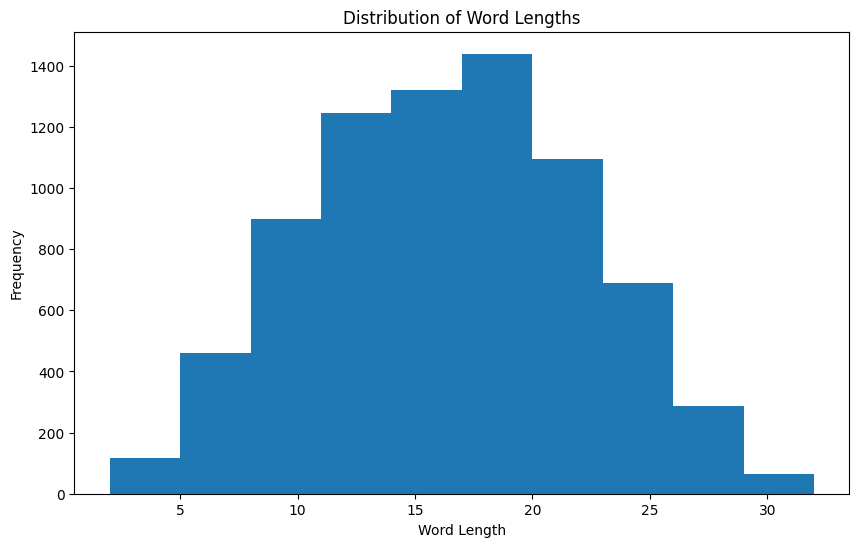

In [46]:
# The distribution of word lengths

word_lengths = train['combined_text'].apply(lambda text: len(text.split()))

plt.figure(figsize=(10, 6))
plt.hist(word_lengths)
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()

In a classification problem, one crucial step is to assess the balance of the data and ensure that each class is approximately equally represented. Based on the pie chart, our model's class distribution appears to be reasonably balanced. As a result, we won't need to employ any specific methods to achieve a more even balance.

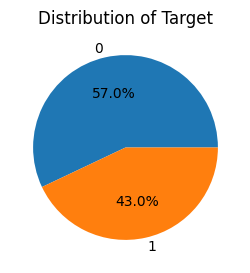

In [15]:
# The balance of dataset

value_counts = train["target"].value_counts()

# plot a pie chart

plt.figure(figsize=(3,3))
plt.pie(value_counts, labels=value_counts.index, autopct="%1.1f%%")
plt.title("Distribution of Target")
plt.show()

For this project, our strategy is to harness the power of the BERT model, renowned for its robustness, to embed our textual data. This process involves converting words into vectors that computers can comprehend, which greatly aids in our text classification efforts. Thanks to BERT's contextual nature, there is no requirement to eliminate punctuation, stopwords, or other elements from our text data. Therefore, there is no need for extensive text data cleaning.

In [16]:
# split the train dataset into trainning and test data

x_train, x_test, y_train, y_test = train_test_split(train["combined_text"],train["target"], test_size=0.2, stratify = train["target"], random_state = 0)



## Model

This hybrid model is designed to tackle the complex task of Twitter text classification by harnessing the capabilities of both BERT and GRU. BERT, renowned for its contextual comprehension of text, serves as the initial encoder for the input text, capturing nuanced relationships between words and phrases in a bidirectional manner. The encoded text, enriched with this contextual understanding, is then seamlessly fed into the GRU model, further enhancing the model's ability to discern and classify tweets effectively. This combination of transformer-based and recurrent neural network architectures empowers our model, offering a robust solution for a wide range of applications.

After extensive experimentation, the following model has emerged as the top performer. It's a complex model with a substantial parameter count, and I've integrated dropout layers to mitigate overfitting and enhance its performance.

In [17]:
# import BERT model

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")



In [18]:
# build the model

# BERT layers
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string, name = "text")
preprocessed_text = bert_preprocess(text_input)
output = bert_encoder(preprocessed_text)

# GRU layers
gru = tf.keras.layers.GRU(128,dropout=0.5,recurrent_dropout=0.5)(output["sequence_output"])
dropout_layer = tf.keras.layers.Dropout(0.5)(gru)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer)


model = tf.keras.Model(inputs=text_input, outputs=output_layer)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [20]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Apply a threshold of 0.5 to the predictions
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))
    actual_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))

    precision = true_positives / (predicted_positives + 1e-7)
    recall = true_positives / (actual_positives + 1e-7)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

    return f1

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

In [21]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
191/191 [==============================] - 2176s 11s/step - loss: 0.5522 - accuracy: 0.7335 - f1_score: 0.6663
Epoch 2/10
191/191 [==============================] - 2138s 11s/step - loss: 0.4655 - accuracy: 0.7946 - f1_score: 0.7348
Epoch 3/10
191/191 [==============================] - 2162s 11s/step - loss: 0.4239 - accuracy: 0.8190 - f1_score: 0.7636
Epoch 4/10
191/191 [==============================] - 2169s 11s/step - loss: 0.3981 - accuracy: 0.8289 - f1_score: 0.7759
Epoch 5/10
191/191 [==============================] - 2159s 11s/step - loss: 0.3856 - accuracy: 0.8404 - f1_score: 0.7931
Epoch 6/10
191/191 [==============================] - 2134s 11s/step - loss: 0.3723 - accuracy: 0.8424 - f1_score: 0.7934
Epoch 7/10
191/191 [==============================] - 2108s 11s/step - loss: 0.3594 - accuracy: 0.8491 - f1_score: 0.8016
Epoch 8/10
191/191 [==============================] - 2133s 11s/step - loss: 0.3496 - accuracy: 0.8534 - f1_score: 0.8068
Epoch 9/10
191/191 [====

In [22]:
model.save("/content/drive/MyDrive/Colab Notebooks/nlp_tweeter_disaster/model_v1_r5.model")

## Model Performance

In [26]:
# load the model

loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/nlp_tweeter_disaster/model_v1_r5.model", custom_objects={'f1_score': f1_score})

In [27]:
# performance on test set of train data

results = loaded_model.evaluate(x_test, y_test)

loss = results[0]
accuracy = results[1]
f1 = results[2]

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.2%}")
print(f"F1 score: {f1:.2%}")

48/48 [==============================] - 569s 12s/step - loss: 0.4353 - accuracy: 0.8306 - f1_score: 0.7749
Test Loss: 0.4353
Test Accuracy: 83.06%
F1 score: 77.49%


According to the results, the accuracy of our model is around 83.06% and F1 score is around 77.49%. And the confusion matrix is shown as following.

In [47]:
test_pred = loaded_model.predict(x_test)

48/48 [==============================] - 554s 11s/step


In [49]:
test_pred_binary = (test_pred > 0.5).astype(int)

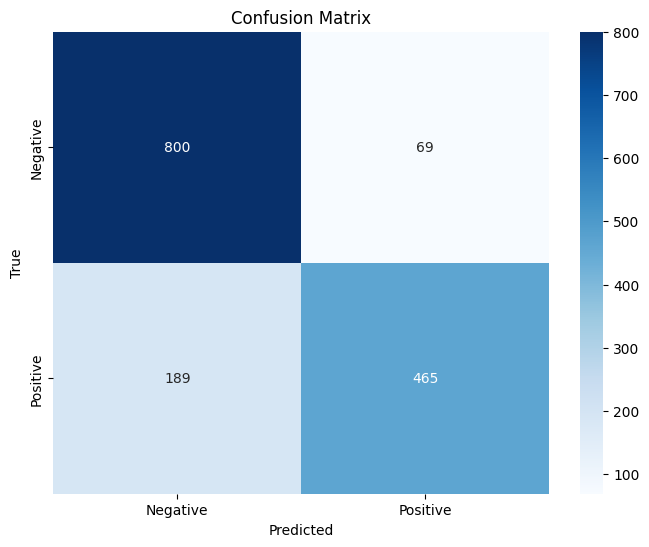

In [51]:
confusion = confusion_matrix(y_test, test_pred_binary)
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Preparation of sumbmission

In [28]:
# make prediction
y_pred = loaded_model.predict(test["combined_text"])

102/102 [==============================] - 1142s 11s/step


In [30]:
y_pred_binary = (y_pred>0.5).astype(int)

In [38]:
submission = {"id":test["id"],"target":y_pred_binary.tolist()}
submission = pd.DataFrame(submission)
submission['target'] = submission['target'].str[0]

In [39]:
submission.head(10)

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [41]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/nlp_tweeter_disaster/submission_v4.csv', index=False)

## Conclusion

In this project, the model demonstrates good performance on the test data, achieving an accuracy of approximately 83.06%. This level of accuracy is promising and reflects the model's ability to make meaningful predictions. However, it's important to note that the complexity of the model has its trade-offs, particularly in terms of longer training times and resource demands. As a result, there is room for improvement in terms of optimizing the model's efficiency. To achieve even higher accuracy and address these challenges, further exploration into more advanced algorithms or model architectures is warranted.

